### Load Library

In [3]:
%matplotlib inline
import os
os.chdir("/Users/liyanran/Desktop/23Fall/STCS6701probML/probML6701/Final")

%env PYTENSOR_FLAGS=device=cpu, floatX=float32, warn_float64=ignore

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
import seaborn as sns

from scipy import stats

print(f"Running on PyMC v{pm.__version__}")


env: PYTENSOR_FLAGS=device=cpu, floatX=float32, warn_float64=ignore


/Users/liyanran/opt/anaconda3/envs/HeatAlert/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Running on PyMC v5.6.1


In [4]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

### Load Data

In [2]:
# read csv
df = pd.read_csv("../../stcs6701_final_project/data/df.csv")
df.head()

,Unnamed: 0,svy_year,demo_age_cat,demo_race,demo_pregnant,demo_gender,bp_control_jnc7,htn_aware,htn_resistant_jnc7,bp_med_use,...,bp_med_diur_thz,cc_smoke,cc_bmi,cc_diabetes,cc_ckd,cc_cvd_mi,cc_cvd_chd,cc_cvd_stroke,cc_cvd_ascvd,cc_cvd_hf
0,1,1999-2000,18 to 44,Non-Hispanic White,0.0,Men,0,0,0,0,...,0.0,Never,30 to <35,0,0,0.0,0.0,0.0,0,0.0
1,2,1999-2000,18 to 44,Non-Hispanic White,0.0,Men,0,0,0,0,...,0.0,Former,30 to <35,0,0,0.0,0.0,0.0,0,0.0
2,3,1999-2000,18 to 44,Hispanic,0.0,Men,0,0,0,0,...,0.0,Former,35+,0,0,0.0,0.0,0.0,0,0.0
3,4,1999-2000,18 to 44,Non-Hispanic White,0.0,Men,0,0,0,0,...,0.0,Former,35+,0,0,0.0,0.0,0.0,0,0.0
4,5,1999-2000,18 to 44,Non-Hispanic White,0.0,Men,1,0,0,0,...,0.0,Former,<25,0,0,0.0,0.0,0.0,0,0.0


In [5]:
print(df.columns)

Index(['Unnamed: 0', 'svy_year', 'demo_age_cat', 'demo_race', 'demo_pregnant',
       'demo_gender', 'bp_control_jnc7', 'htn_aware', 'htn_resistant_jnc7',
       'bp_med_use', 'bp_med_recommended_jnc7', 'bp_med_n_class',
       'bp_med_n_pills', 'bp_med_combination', 'bp_med_pills_gteq_2',
       'bp_med_ace', 'bp_med_aldo', 'bp_med_alpha', 'bp_med_angioten',
       'bp_med_beta', 'bp_med_ccb', 'bp_med_central',
       'bp_med_renin_inhibitors', 'bp_med_vasod', 'bp_med_diur_loop',
       'bp_med_diur_Ksparing', 'bp_med_diur_thz', 'cc_smoke', 'cc_bmi',
       'cc_diabetes', 'cc_ckd', 'cc_cvd_mi', 'cc_cvd_chd', 'cc_cvd_stroke',
       'cc_cvd_ascvd', 'cc_cvd_hf'],
      dtype='object')


In [8]:
mapping = {
    "1999-2000": 1,
    "2001-2002": 2,
    "2003-2004": 3,
    "2005-2006": 4,
    "2007-2008": 5,
    "2009-2010": 6,
    "2011-2012": 7,
    "2013-2014": 8,
    "2015-2016": 9,
    "2017-2020": 10
}

df['year_group'] = df['svy_year'].map(mapping)

In [13]:
df.columns

Index(['Unnamed: 0', 'svy_year', 'demo_age_cat', 'demo_race', 'demo_pregnant',
       'demo_gender', 'bp_control_jnc7', 'htn_aware', 'htn_resistant_jnc7',
       'bp_med_use', 'bp_med_recommended_jnc7', 'bp_med_n_class',
       'bp_med_n_pills', 'bp_med_combination', 'bp_med_pills_gteq_2',
       'bp_med_ace', 'bp_med_aldo', 'bp_med_alpha', 'bp_med_angioten',
       'bp_med_beta', 'bp_med_ccb', 'bp_med_central',
       'bp_med_renin_inhibitors', 'bp_med_vasod', 'bp_med_diur_loop',
       'bp_med_diur_Ksparing', 'bp_med_diur_thz', 'cc_smoke', 'cc_bmi',
       'cc_diabetes', 'cc_ckd', 'cc_cvd_mi', 'cc_cvd_chd', 'cc_cvd_stroke',
       'cc_cvd_ascvd', 'cc_cvd_hf', 'year_group'],
      dtype='object')

In [26]:
# print column names
print(df.columns)

Index(['Unnamed: 0', 'svy_year', 'demo_age_cat', 'demo_race', 'demo_pregnant',
       'demo_gender', 'bp_control_jnc7', 'htn_aware', 'htn_resistant_jnc7',
       'bp_med_use', 'bp_med_recommended_jnc7', 'bp_med_n_class',
       'bp_med_n_pills', 'bp_med_combination', 'bp_med_pills_gteq_2',
       'bp_med_ace', 'bp_med_aldo', 'bp_med_alpha', 'bp_med_angioten',
       'bp_med_beta', 'bp_med_ccb', 'bp_med_central',
       'bp_med_renin_inhibitors', 'bp_med_vasod', 'bp_med_diur_loop',
       'bp_med_diur_Ksparing', 'bp_med_diur_thz', 'cc_smoke', 'cc_bmi',
       'cc_diabetes', 'cc_ckd', 'cc_cvd_mi', 'cc_cvd_chd', 'cc_cvd_stroke',
       'cc_cvd_ascvd', 'cc_cvd_hf', 'year_group'],
      dtype='object')


In [28]:
# select columns

ts = df[['year_group', 'bp_control_jnc7', "htn_aware", "bp_med_use",'bp_med_recommended_jnc7', 'cc_cvd_stroke', "htn_aware"]]

In [35]:
ts = ts.dropna()
ts.head()

,year_group,bp_control_jnc7,htn_aware,bp_med_use,bp_med_recommended_jnc7,cc_cvd_stroke,htn_aware
0,1,0,0,0,0,0.0,0
1,1,0,0,0,0,0.0,0
2,1,0,0,0,0,0.0,0
3,1,0,0,0,0,0.0,0
4,1,1,0,0,0,0.0,0


ValueError: x and y must be the same size

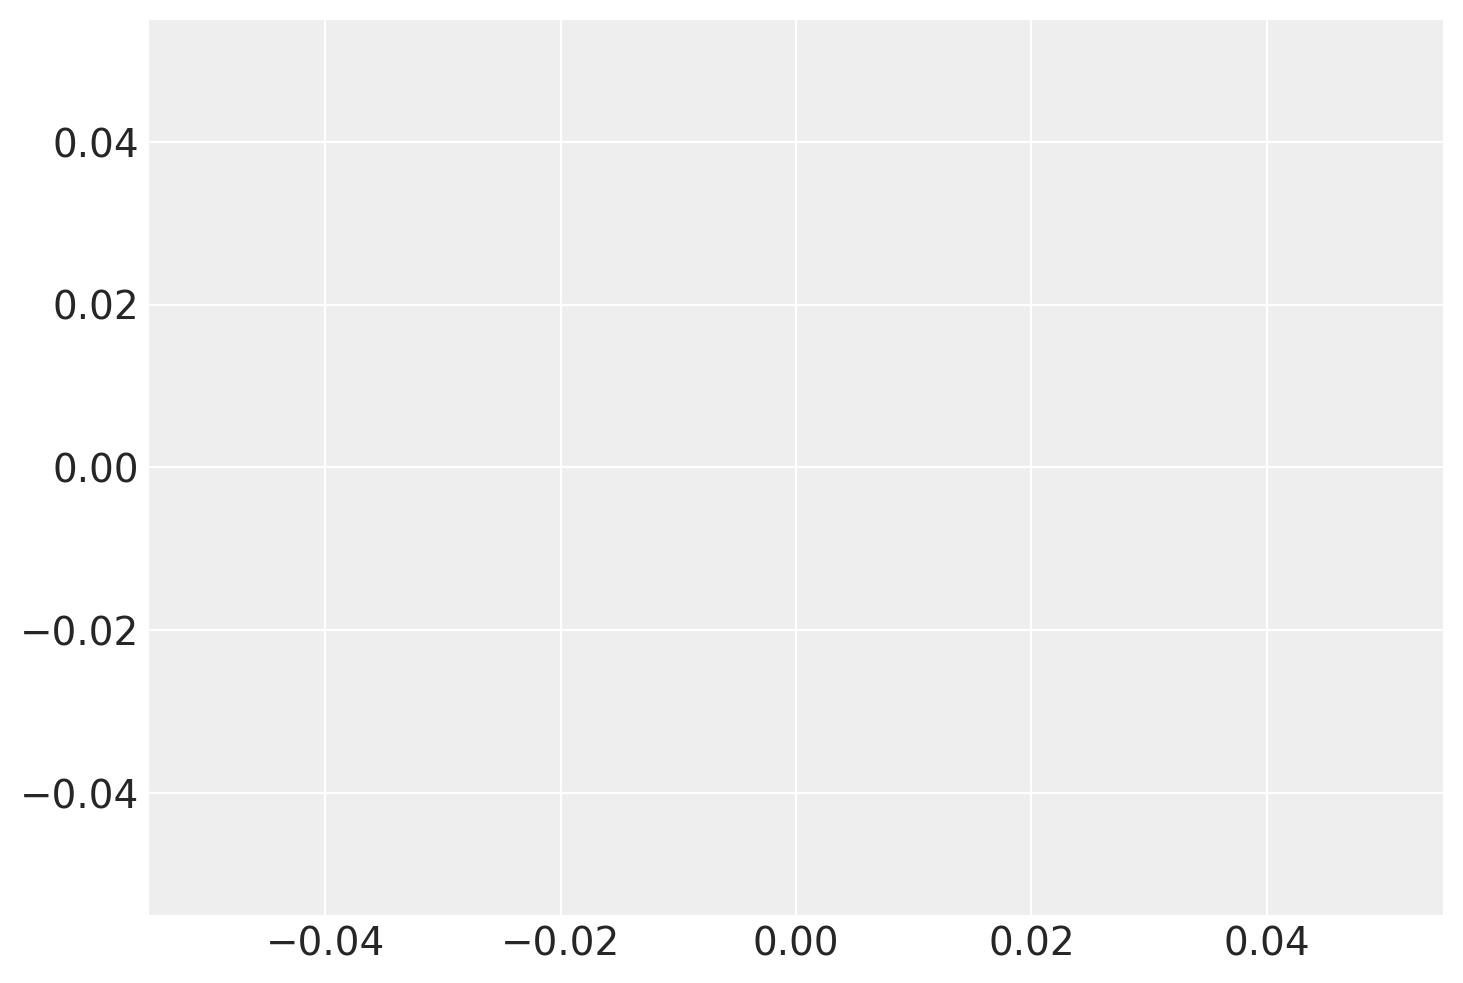

In [36]:
group_list = [1,2,3,4,5,6,7,8,9,10]

for i, group in enumerate(group_list):
    plt.scatter(
        ts.query(f"year_group=={i}").htn_aware,
        ts.query(f"year_group=={i}").bp_control_jnc7,
        color=f"C{i}",
        label=f"{group}",
    )
plt.legend(title="group");

In [51]:
ts = ts.dropna()
county_idxs, counties = pd.factorize(ts.county)
coords = {
    "county": counties,
    "obs_id": np.arange(len(county_idxs)),
}

In [7]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb

from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = "retina"

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.6.1


In [8]:
ts = ts.dropna()

features = ["pm25", "smoke_rate", "population", "weekday"]

X = ts[features]
Y = ts["HImaxF_PopW"]

In [42]:
ts.shape

(442338, 32)

In [41]:
ts.head()

,StateCounty_FIPS,Date,HImaxF_PopW,county,warn,adv,alert,year,pm25,summer_tmmx,...,white_pct,native_pct,asian_pct,no_grad,no_grad_mcare,median_household_income,owner_occupied,median_age,population_density,weekday
214,1001.0,2007-04-01,75.806902,Autauga,0.0,0.0,0.0,2007.0,12.803966,307.346143,...,0.789279,0.005435,0.008215,0.264989,0.27476,52323.0,0.769648,36.342857,86.857194,0.0
215,1001.0,2007-04-02,83.541869,Autauga,0.0,0.0,0.0,2007.0,12.803966,307.346143,...,0.789279,0.005435,0.008215,0.264989,0.27476,52323.0,0.769648,36.342857,86.857194,1.0
216,1001.0,2007-04-03,84.437570,Autauga,0.0,0.0,0.0,2007.0,12.803966,307.346143,...,0.789279,0.005435,0.008215,0.264989,0.27476,52323.0,0.769648,36.342857,86.857194,1.0
217,1001.0,2007-04-04,74.225980,Autauga,0.0,0.0,0.0,2007.0,12.803966,307.346143,...,0.789279,0.005435,0.008215,0.264989,0.27476,52323.0,0.769648,36.342857,86.857194,1.0
218,1001.0,2007-04-05,57.881057,Autauga,0.0,0.0,0.0,2007.0,12.803966,307.346143,...,0.789279,0.005435,0.008215,0.264989,0.27476,52323.0,0.769648,36.342857,86.857194,1.0


In [9]:

with pm.Model() as model_bikes:
    α = pm.Exponential("α", 1)
    μ = pmb.BART("μ", X, np.log(Y), m=50)
    y = pm.NegativeBinomial("y", mu=pm.math.exp(μ), alpha=α, observed=Y)
    idata_bikes = pm.sample(compute_convergence_checks=False, random_seed=123)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ]
/Users/liyanran/opt/anaconda3/envs/HeatAlert/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/liyanran/opt/anaconda3/envs/HeatAlert/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/Users/liyanran/opt/anaconda3/envs/HeatAlert/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16093 seconds.


/Users/liyanran/opt/anaconda3/envs/HeatAlert/lib/python3.8/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


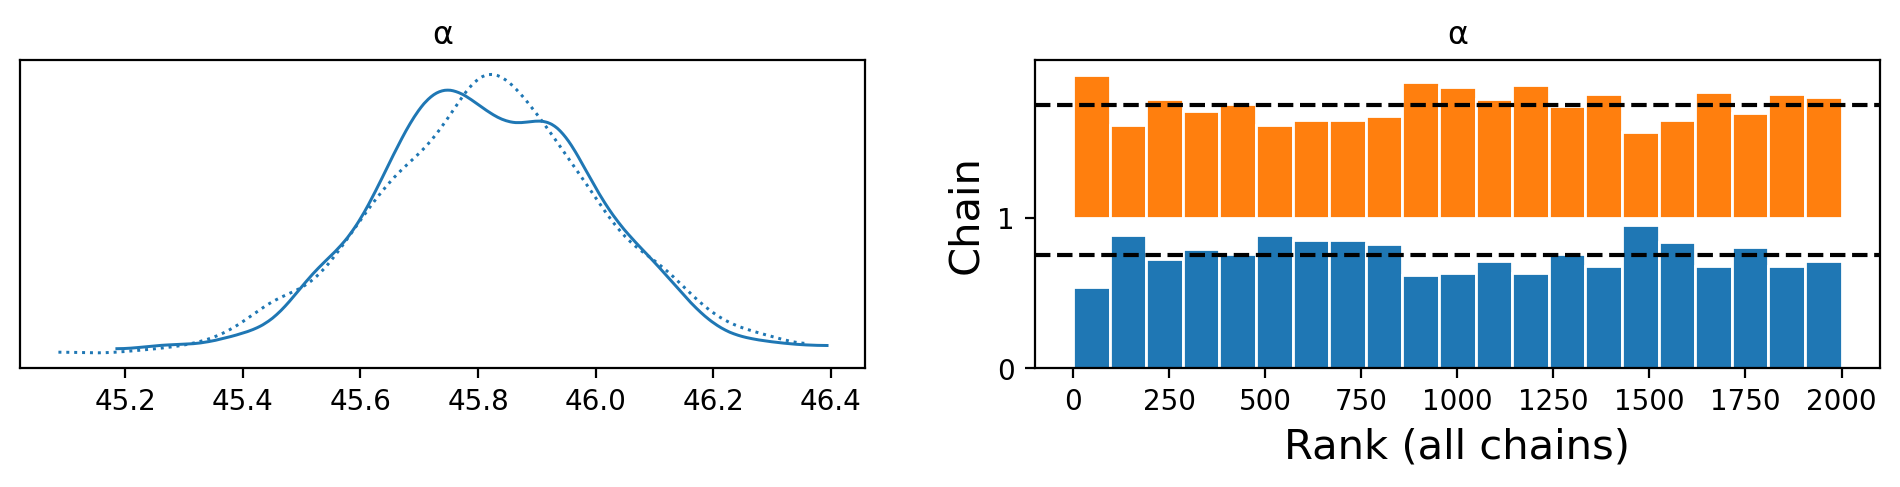

In [10]:
az.plot_trace(idata_bikes, var_names=["α"], kind="rank_bars");

/Users/liyanran/opt/anaconda3/envs/HeatAlert/lib/python3.8/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


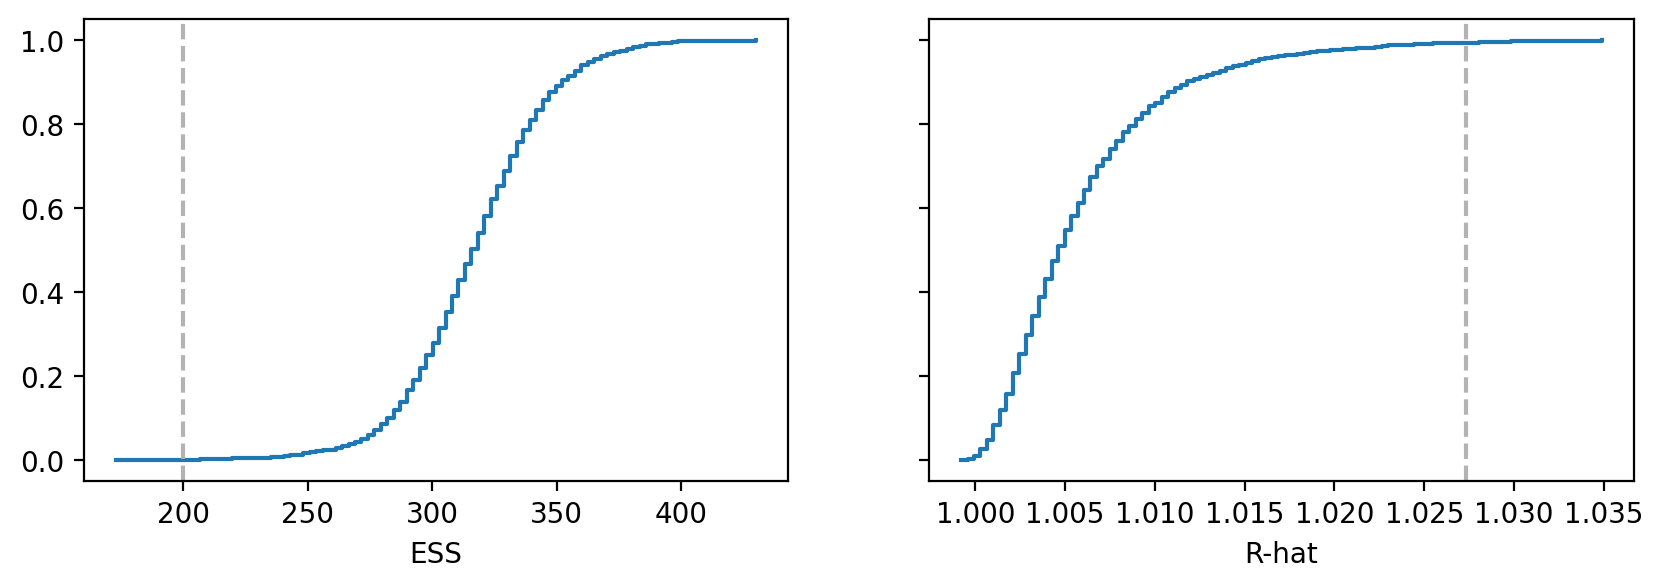

In [11]:
pmb.plot_convergence(idata_bikes, var_name="μ");

In [ ]:
az.plot_trace(idata_bikes, var_names=["\u03BC"]);

/Users/liyanran/opt/anaconda3/envs/HeatAlert/lib/python3.8/site-packages/pymc_bart/utils.py:786: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  chains_hdi = az.hdi((var_imp_chains.T / var_imp_chains.sum(axis=1)).T)[indices]


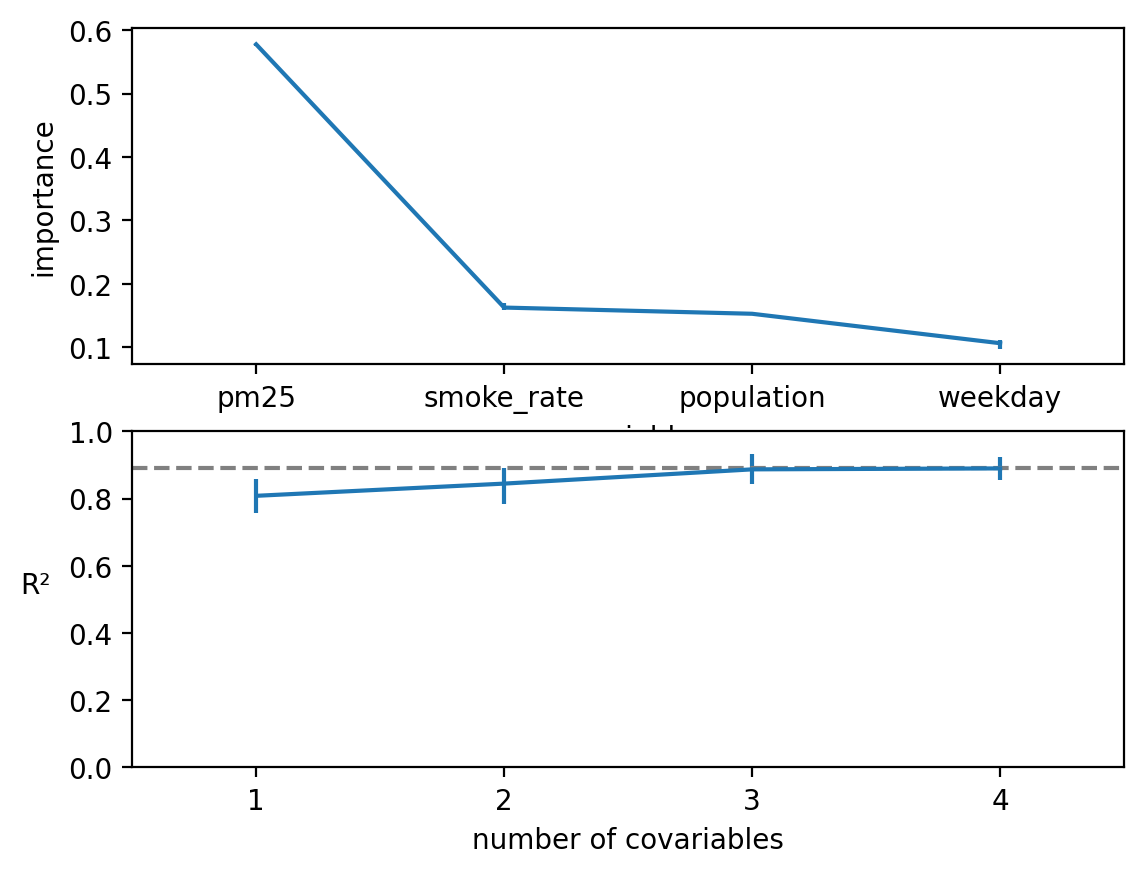

In [25]:
pmb.plot_variable_importance(idata_bikes, μ, X, samples=100);

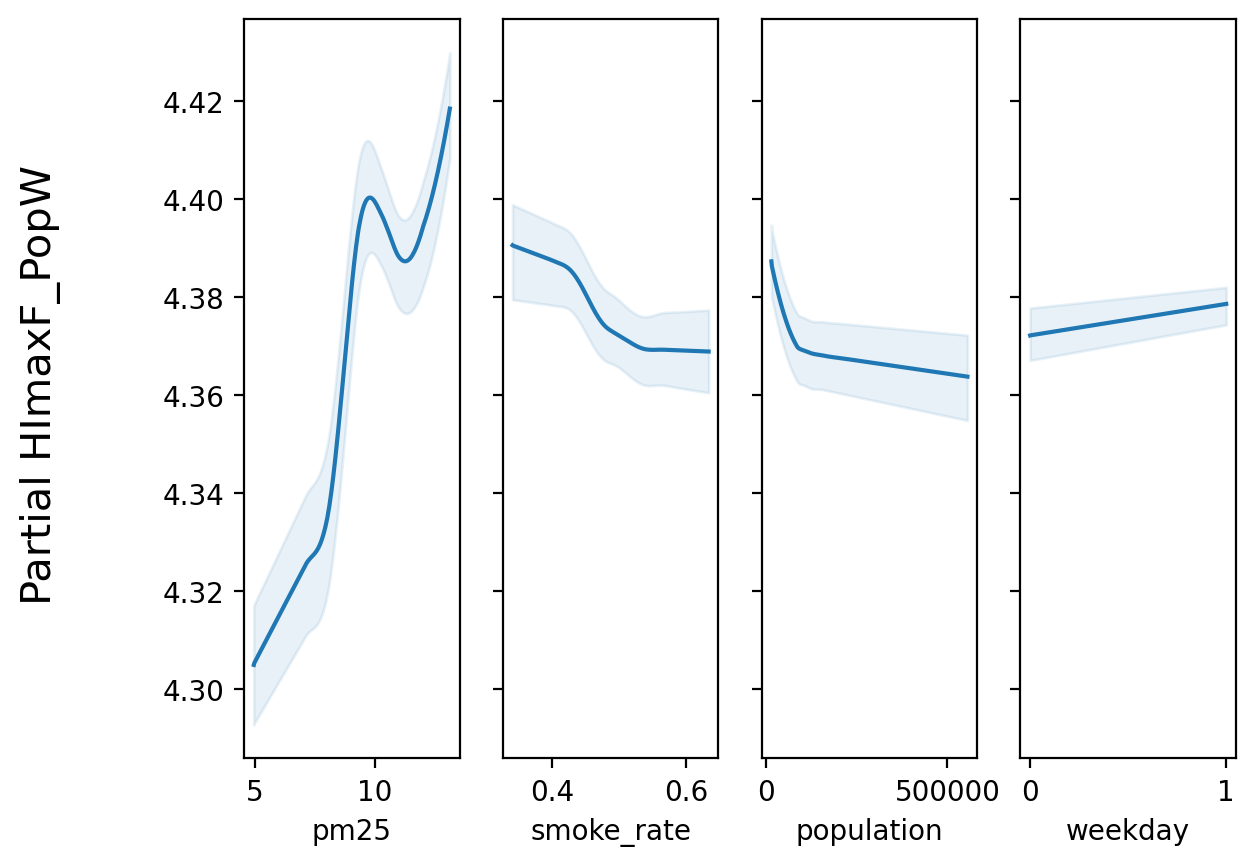

In [37]:
pmb.plot_pdp(μ, X=X, Y=Y, grid=(1,4));



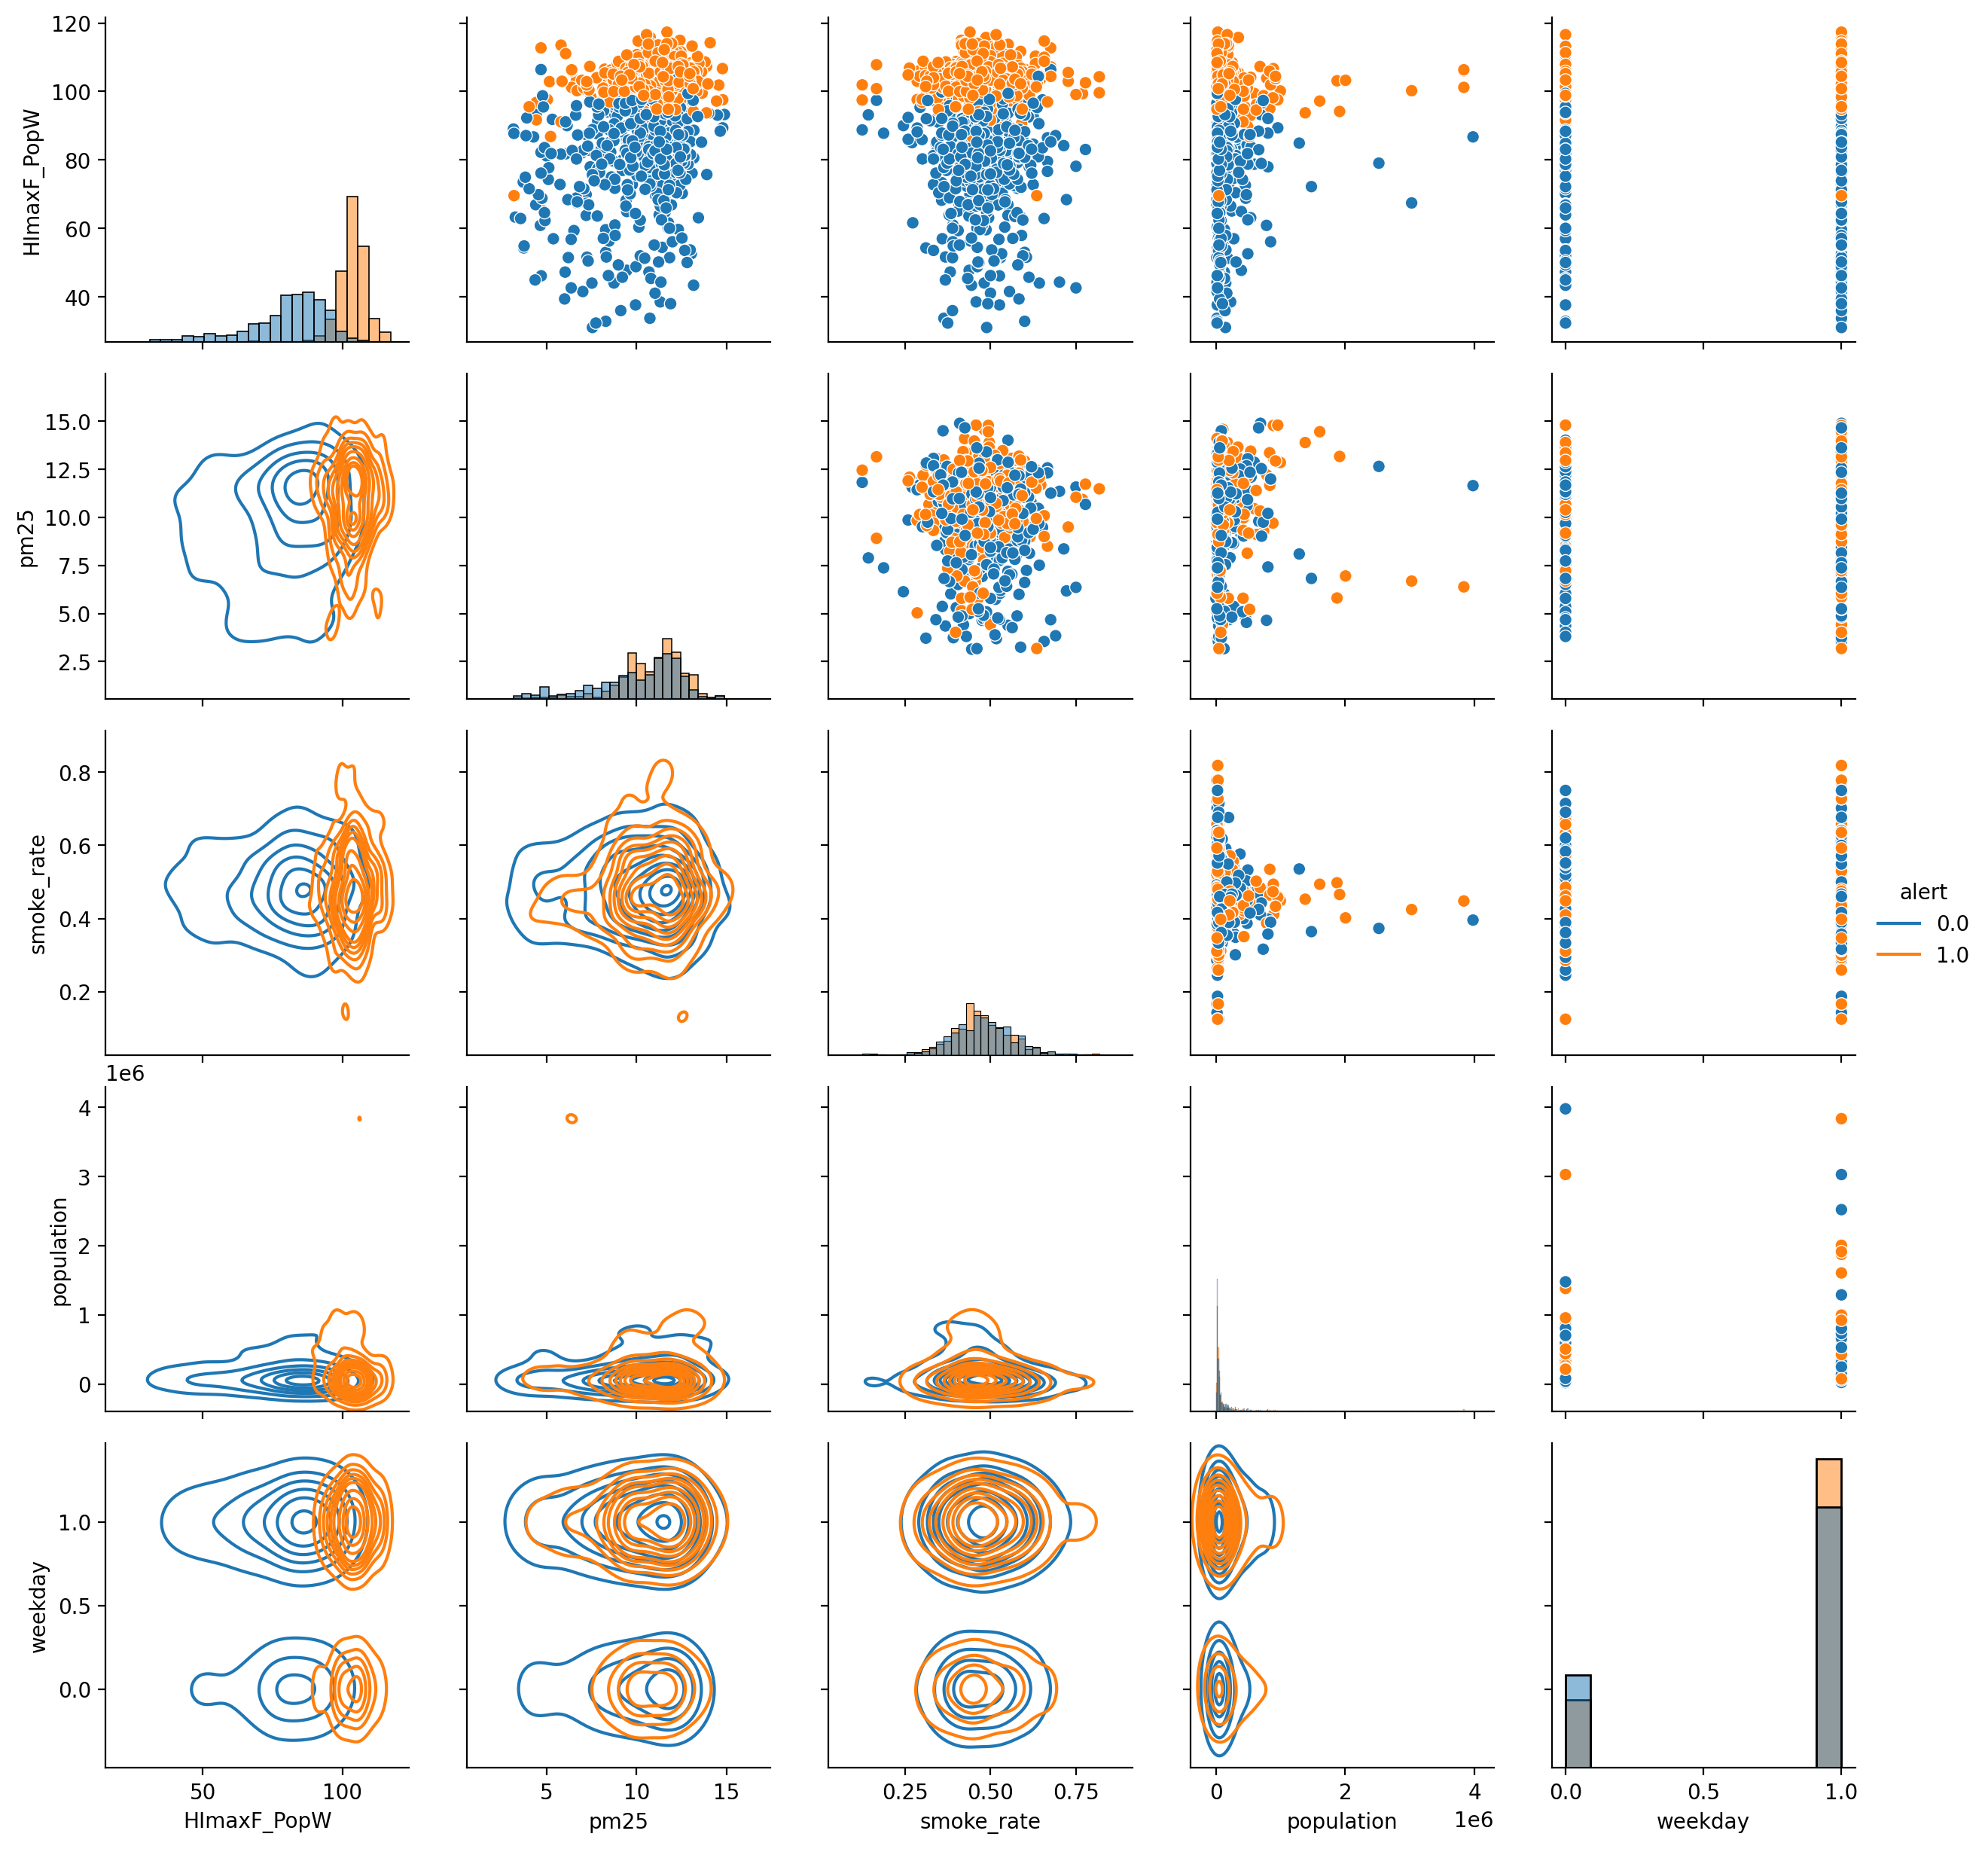

In [39]:
np.random.seed(42)
t = ts[["alert","HImaxF_PopW", 'pm25', 'smoke_rate', "population", "weekday"]].copy()

t.replace({r"\N": np.nan}, inplace=True)
t.dropna(subset=["pm25"], inplace=True)
t = t.astype(float)

n = len(t[t["alert"]==1])
t = pd.concat([t[t["alert"]==1], t[t["alert"]==0].sample(n)], axis=0).sample(1000)
g = sns.PairGrid(t, hue="alert")
g.map_diag(sns.histplot)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.add_legend()

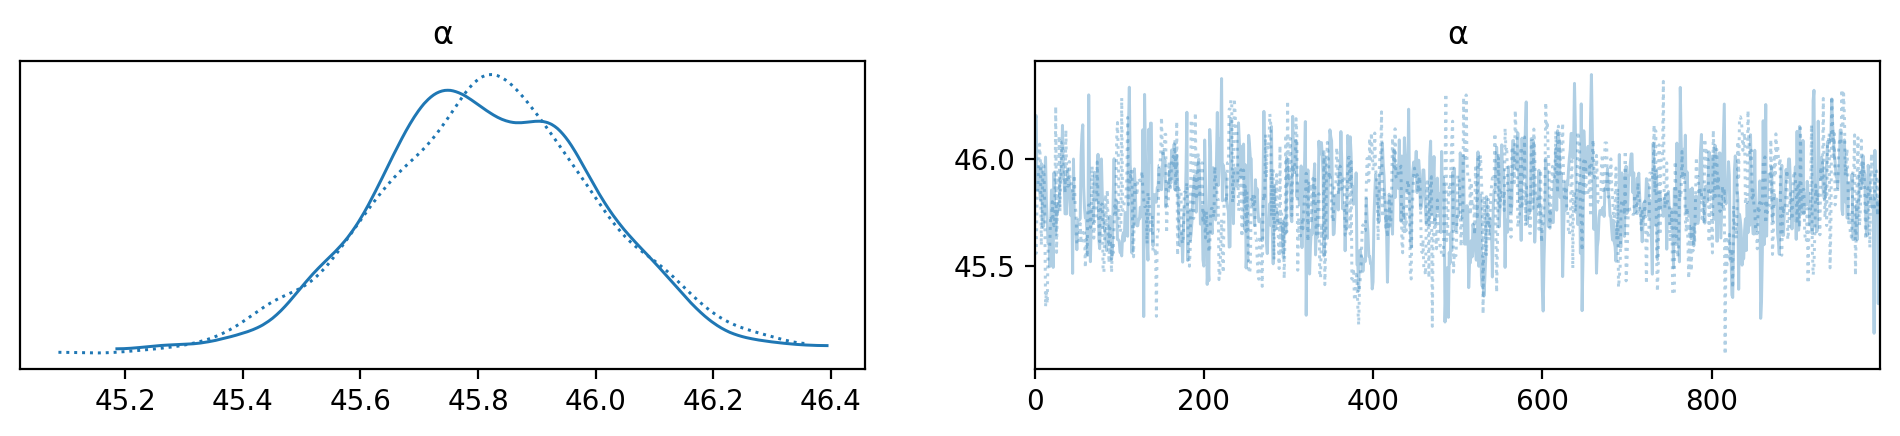

In [45]:
az.plot_trace(idata_bikes, var_names=["α"], kind='trace');

In [ ]:
az.plot_trace(idata_bikes, var_names=["μ"], kind='trace');

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=325)

In [50]:
with pm.Model() as model_oos_regression:
    X = pm.MutableData("X", X_train)
    Y = Y_train
    α = pm.Exponential("α", 1)
    μ = pmb.BART("μ", X, np.log(Y))
    y = pm.NegativeBinomial("y", mu=pm.math.exp(μ), alpha=α, observed=Y, shape=μ.shape)
    idata_oos_regression = pm.sample(random_seed=325)
    posterior_predictive_oos_regression_train = pm.sample_posterior_predictive(
        trace=idata_oos_regression, random_seed=325
    )

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ]
/Users/liyanran/opt/anaconda3/envs/HeatAlert/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/liyanran/opt/anaconda3/envs/HeatAlert/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/Users/liyanran/opt/anaconda3/envs/HeatAlert/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16830 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


In [55]:
with model_oos_regression:
    X.set_value(X_test)
    posterior_predictive_oos_regression_test = pm.sample_posterior_predictive(
        trace=idata_oos_regression, random_seed=325
    )

Sampling: [y, μ]
